# Assignment 4

## Grade: /100 pts

Once you are finished, ensure to complete the following steps.
1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.
2.  Fix any errors which result from this.
3.  Repeat steps 1. and 2. until your notebook runs without errors.
4.  Submit your completed notebook to OWL by the deadline.

In [164]:
# Add the necessary imports for this homework 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model
from scipy.stats import t

### Question 1: /15pts

1. Load in the `hockey_draftees_2005.csv` data into pandas. It contains data from hockey players drafted in 2005, including their rank, weight (wt - in pounds) and height (ht - in inches). 

2. Fit a linear model of weight (`wt`) explained by height (`ht`) using a linear regression model from sklearn, as done in the lab tutorial (Week 6).  Call your fitted model `model`.  

3. Make a scatter plot of the height (x-axis) against weight (y-axis). Add the predicted values for 66-80 inches. 

4. Calculate the residuals from the fit, and report the r-squared for this model.

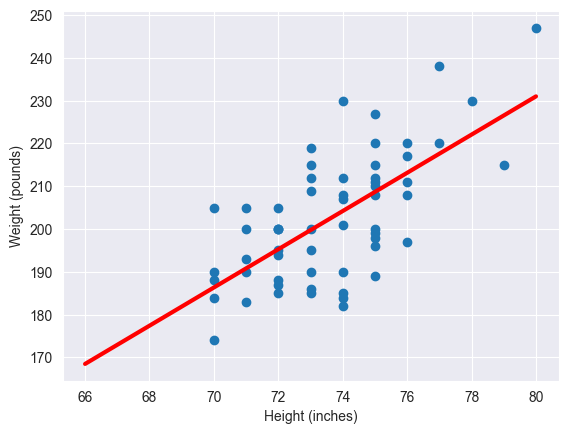

R-squared: 0.43807746842392215
Model Coefficient: [4.46509731]


In [165]:
df = pd.read_csv('hockey_draftees_2005.csv')

X = np.c_[df['ht']]
y = df['wt']

model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

plt.scatter(X, y)
plt.xlabel('Height (inches)')
plt.ylabel('Weight (pounds)')

X_pred = np.linspace(66, 80, 30)
y_pred = model.predict(np.c_[X_pred])
plt.plot(X_pred, y_pred, color='red', linewidth=3)
plt.show()

y_pred_total = model.predict(X)
res = y - y_pred_total
RSS = np.sum(res**2)
TSS = np.sum((y - y.mean())**2)
R2 = 1 - RSS / TSS 
print(f'R-squared: {R2}')
print(f'Model Coefficient: {model.coef_}')

### Question 2:  /25pts

### Bootstrap confidence intervals on parameters

How confident can we be about the relation between height and weight? 
To judge this we need confidence intervals let's use the bootstrap.

1. Modify the function `BootstrapCoef` from lab tutorial (Week 6) - part 2 to conduct a boostrap analysis for this regression model; 

 * `data`, which is a dataframe having columns 'weight' and 'height'
 * `numboot` which is an integer denoting how many bootstrap replications to perform.

2. Write `bootstrap` to perform bootstrap resampling. You can use `pd.DataFrame.sample` with `replace = True` to perform the resampling.  `bootstrap` should return:
  params: a numpy array of size [numboot,numParams] of bootstraped parameter values. The parameters are the intercept value and the slope from the linear regression. 

  *Tip: Note that the intercept can be retrieved from model.intercept_, whereas all the other regression coefficients are stored in model.coef_. 

Here is the documentation for `pd.DataFrame.sample`: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

3. Then call the function to get 100 boostrap samples for your linear regression model of wt explained by height. 
4. Make a joint scatter plot of the parameter value for the intercept and for the slope. 


5. **Written answer:** What do you notice? Why do you think the estimate for the intercept has such a high negative correlation with the slope? 

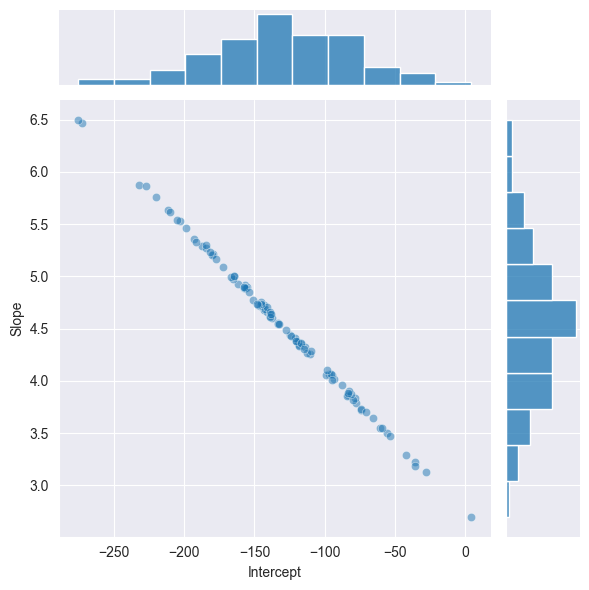

In [166]:
def BootstrapCoef(data, numboot):
    n = len(data)
    theta = np.empty((0,2))
    
    for i in range(numboot):
        d = data.sample(n,replace=True)
        x_b = d['ht'].values
        X_b = np.c_[np.ones(d.shape[0]), x_b]
        y_b = d['wt'].values
        m = sklearn.linear_model.LinearRegression()
        m.fit(X_b, y_b)
 
        boot_intercepts = m.intercept_
        boot_coef = m.coef_[1]
        theta = np.append(theta, np.array([[boot_intercepts, boot_coef]]), axis=0)
        
    return theta

b_df = pd.read_csv('hockey_draftees_2005.csv')
theta = BootstrapCoef(b_df, 100)
theta_df = pd.DataFrame(theta, columns=['Intercept', 'Slope'])

sns.jointplot(data=theta_df, x='Intercept', y='Slope', alpha=0.5, kind='scatter')
plt.xlabel("Intercept")
plt.ylabel("Slope")
plt.show()

**Written answer**: Immediately you can notice the strong collinearity between the intercept and slope regressors. The reason for the intercept estimate showing a significant negative correlation with the slope is that we did not subtract the mean of the height before the regression.

### Question 3: /20pts

1. Plot the bootstrap estimates for the slope as a histogram.  

2. Use your samples to compute a 95% confidence interval. Note that the CI should be constructed around the sample estimate of the slope. 

3. **Written answer:** How can you interpret this confindence interval?  

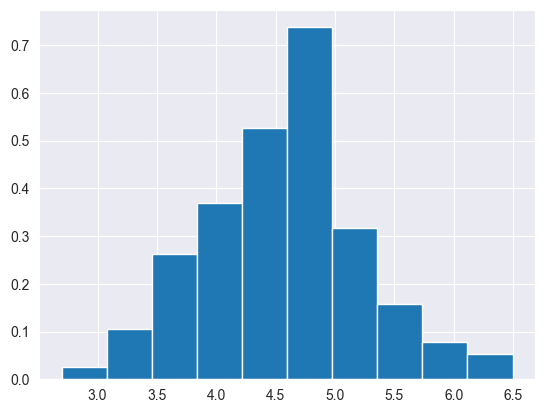

My confidence interval is between [3.06305103] and [5.72979043]


In [167]:
bs_res = theta[:, 1] - model.coef_
plt.hist(theta[:, 1], edgecolor='white', density=True)
ci_lower, ci_upper = np.quantile(bs_res, [0.025, 0.975])
boot_ci = [model.coef_ - ci_upper, model.coef_ - ci_lower]
plt.show()

print(f'My confidence interval is between {boot_ci[0]} and {boot_ci[1]}')

**Written answer:** This confidence interval's interpretation is based on the observation that it encompasses the actual slope parameter with a 95% probability.

### Question 4: /20pts

1. Modify the function `BootstrapPred` from lab tutorial (Week 6) to bootstrap your fit and generate a predict from each of these bootstrapped models.  

2. Draw again a scatter plot of ht against weight. and plot the predictions from the 20 fitted bootstrap models to derive predictions for the height ranging from 60 to 88. Draw all these lines onto your scatter plot. 

3. **Written answer:** Where are we most uncertain in our prediction about the weight of a player? How does the negative correlation between slope and intercept play a role here?  Why is the spread of the prediction in the mean weight so much lower than the variability of our intercept parameter? 

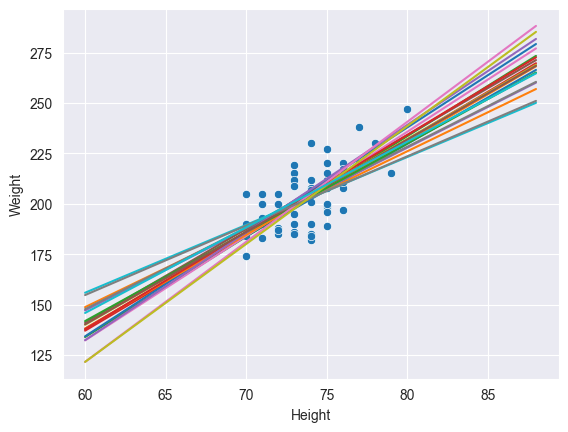

In [168]:
def BootstrapPred(data, xp):
    numboot = 1000
    n = len(data)
    Xb_pred = np.c_[np.ones(xp.size), xp] 
    yb_pred = np.zeros((numboot, xp.shape[0]))
    
    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_boot = np.c_[np.ones(data.shape[0]), d['ht']] 
        reg = sklearn.linear_model.LinearRegression()
        reg.fit(X_boot, d['wt'])
        yb_pred[i,:] = reg.predict(Xb_pred)
        
    return yb_pred

sns.scatterplot(x=df['ht'], y=df['wt'])
plt.xlabel("Height")
plt.ylabel("Weight")
x_line = np.linspace(60,88,59)
yb_pred = BootstrapPred(b_df, x_line) 

for i in range(20):
    plt.plot(x_line, yb_pred[i,:])
plt.show()

**Written answer:** We are most uncertain in our prediction about the weight of a player when their height is very small or very tall. All lines are quite similar in their prediction for the players of middle weight. For the lines to cross in the middle of the graph, a large slope needs to have a small intercept and a small slope needs to have a large intercept. The spread of the prediction in the mean weight is much lower than the variability of our intercept parameter. The variability is affected based on the sample size. A sample size of 100 taken from the same data will give you a different result than a sample size of 1000.

### Question 5:  /20pts

Now, let's see how well our model performs on out-of-sample (a separate test set).  

1. Load in the `hockey_draftees_test.csv` file into a dataframe.  

2. Use your fitted `model` to make predictions. 

3. Make a scatter plot of the test data and superimpose the prediction of the model. 

4. To evaluate this prediction, calculate the r-square value for the out of sample (oos) data.  Statsmodels doesn't provide a function to compute r-squared on new data.  You will have to write one yourself or find one that performs the computation for you.

Out of sample r2 is -0.015001136144207727


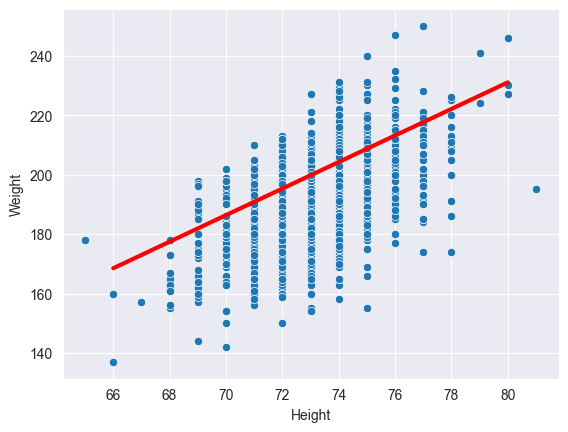

In [169]:
df_test = pd.read_csv('hockey_draftees_test.csv')

sns.scatterplot(x=df_test['ht'], y=df_test['wt'])
plt.xlabel('Height')
plt.ylabel('Weight')

xp = np.linspace(66, 80, 30)
yp = model.predict(np.c_[xp])
plt.plot(xp, yp, linewidth=3, color='red')

y = df_test['wt']
yhat = model.predict(np.c_[df_test['ht']])
r2_oos = 1 - (np.sum((y - yhat)**2)) / (np.sum((y - y.mean())**2))
print(f'Out of sample r2 is {r2_oos}')